## Overview

Automatic image processing is a key component to many AI systems, including facial recognition and video compression, instance segmentation of images and point cloud data. One basic method for processing is segmentation, by which we divide an image into a fixed number of components in order to simplify its representation. For example, we can train a mixture of Gaussians to represent an image.

In this assignment, you will learn to perform image compression and point cloud segmentation. To this end, you will implement Gaussian mixture models and iteratively improve their performance. First you will perform segmentation on the "Bird" (`bird_color_24.png`) and at the end run your algorithm on 3D point cloud data.


1. Implement k-means clustering to segment a color image.

2. Familiarize yourself with the algorithm by running it on simple dataset.

3. Build a Gaussian mixture model to be trained with expectation-maximization.

4. Experiment with varying the details of the Gaussian mixture model’s implementation.

5. Implement and test a new metric called the Bayesian information criterion, which guarantees a more robust image segmentation.



## Part 1: K-means Clustering

One easy method for image segmentation is to simply cluster all similar data points together and then replace their values with the mean value. Thus, we'll warm up using k-means clustering. This will also provide a baseline to compare with your segmentation. 


In [1]:
%load_ext autoreload
%autoreload 2
# Run this cell and check if you have all necessary modules
from IPython.html.widgets import *
import mixture_tests as tests
import matplotlib.pyplot as plt
import os
import numpy as np
from helper_functions import *
# Please don't modify this cell

C:\Users\zm988w\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# DON'T RUN THIS CELL IT WILL THROW AN ERROR
# IF YOU ACCIDENTALL RUN IT, IT'S OK, YOU CAN IGNORE THE ERRORS
import numpy as np
from .helper_functions import *

ModuleNotFoundError: No module named '__main__.helper_functions'; '__main__' is not a package

In [3]:
#import random
def get_initial_means(array, k):
    """
    Picks k random points from the 2D array 
    (without replacement) to use as initial 
    cluster means

    params:
    array = numpy.ndarray[numpy.ndarray[float]] - m x n | datapoints x features

    k = int

    returns:
    initial_means = numpy.ndarray[numpy.ndarray[float]]
    """
    
        
    list_len = array.shape[0] # number rows in data
    random_list = np.random.choice(list_len, k, replace=False) # list of elements to sample
    initial_means = array[[random_list]]
    
    return initial_means 
          
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.K_means_test().test_initial_means(get_initial_means)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [4]:
def k_means_step(X, k, means):
    """
    A single update/step of the K-means algorithm
    Based on a input X and current mean estimate
    calculate new means and predict clusters for each of the pixel
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n | pixels x features (already flattened)
    k = int
    means = numpy.ndarray[numpy.ndarray[float]] - k x n

    returns:
    new_means = numpy.ndarray[numpy.ndarray[float]] - k x n
    clusters = numpy.ndarray[int] - m sized vector
    """

    #calculate the euclidean distance for each initial mean
    eucs=[]
    for i in range(k):
        mean = means[i]
        eucl_mean = np.linalg.norm(X-mean, axis=1)
        eucs.append(eucl_mean)
    eucs_array=np.array(eucs).T
    
    # get the element of smallest mean
    args = np.argmin(eucs_array,axis = 1)
    clusters = args.reshape(-1,1)
    
    # for each of the cluster values [0,1,2,...k] replace values with the mean values of the smallest mean
    new_means = []
    for i in range(k):
        this_cluster_ids = np.where(clusters[:,0]==i)
        this_cluster_rows = X[[this_cluster_ids]]
        this_cluster_new_mean = np.mean(this_cluster_rows, axis = 1).flatten()
        # in case there is a cluster that has 0 values close to it rewrite nan with 0
        this_cluster_new_mean = [0.0 if np.isnan(i) else i for i in this_cluster_new_mean]
        new_means.append(this_cluster_new_mean)
    
    new_means = np.array(new_means)

    return new_means, clusters
        

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.K_means_test().test_k_means_step(k_means_step)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


#### K-means - Visualizing the results

Now that you are done with the K-means step implementation lets try to visualize what's happening if you repeat these steps multiple times.

**You don't need to be implementing anything in the next cells until Image Segmentation Section**, but you are highly encouraged to play with parameters and datasets, to get a sense of what is happening at every algorithm iteration step.

Feel free to explore and improve the function below, it will be used for visualizing K-means progress
but it's not required and WON'T effect your grade.

In [5]:
# This cell contains a code for loading a dataset from the `data` folder
# Each of these datasets contains synthtic (generated) data
# You can simply run this cell for now and come back to it later if you want to make changes
# Make sure you implemented everything in cells above and passed the unittests
def K_means_2D_dataset(dataset_index, K):
    # Load the dataset from data folder
    X = np.loadtxt("data/%d_dataset_X.csv" % dataset_index, delimiter=",")
    #print("The dataset is of a size:", X.shape)

    # Load the labels
    # Clustering is unsupervised method, where no labels are provided
    # However, since we generated the data outselves we know the clusters,
    # and load them for illustration purposes.
    y = np.int16(np.loadtxt("data/%d_dataset_y.csv" % dataset_index, delimiter=","))

    # Feel free to edit the termination condition for the K-means algorithm
    # Currently is just runs for n_iterations, before terminating
    n_iterations = 10
    m,n = X.shape
    means = get_initial_means(X,K)
    clusters = np.zeros([n])
    # keeping track of how clusters and means changed, for visualization purposes
    means_history = [means]
    clusters_history = [clusters] 
    #print("clusters_history: ", clusters_history)
    for iteration_i in range(n_iterations):
        means, clusters = k_means_step(X, K, means)
        clusters_history.append(clusters)

    return X, y, means_history, clusters_history

# Things to try:
# - Try different initialization to see check initialization robustness
# - Improve the termination condition (you will be able to reuse later as well!)
# - Try creating you own dataset in the `data/` folder 

interactive(children=(IntSlider(value=5, description='i', max=10, min=1), Output()), _dom_classes=('widget-int…

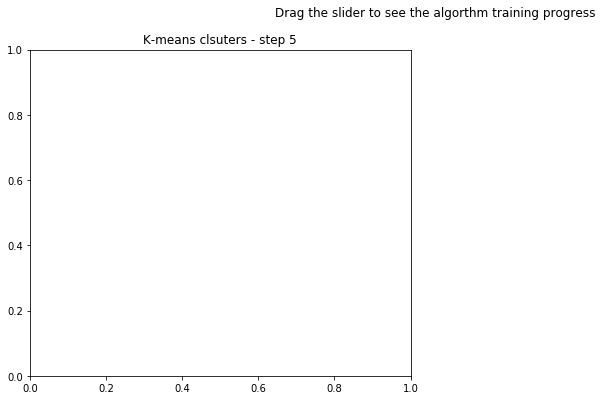

In [6]:
# RUN - TRY DIFFERENT PARAMETERS - REPEAT
dataset_index = 2 # for different dataset change it to number from [0,4]
K = 5 # Number of clusters - play with this number

X, y, means_history, clusters_history = K_means_2D_dataset(dataset_index, K)

# This is an interactive cell to see the progress of training your K-means algorithm.
# Feel free to improve the visualization code and share it with your classmates on Piazza
def get_cluster(i):
    clusters = clusters_history[i] # Get the clusters from K-means' i-th iteration
    plt.figure(None, figsize=(15,6)) # Set the plot size
    plt.suptitle('Drag the slider to see the algorthm training progress')
    ax1=plt.subplot(1, 2, 1)
    ax1.set_title('K-means clsuters - step %d' % i)
    for k in range(K):
        plt.plot(X[clusters==k,0], X[clusters==k,1], '.') # 
        # Try to plot the centers of the clusters 
        # You can access them by calling means_history[i]
        # How could you plot the area that belong to that cluster?

    # Just to get a flavour of how the data looks like
    ax2=plt.subplot(1, 2, 2)
    ax2.set_title('Ground truth clusters')
    for i in np.unique(y):
        ax2.plot(X[y==i,0],X[y==i,1],'.')

    plt.show()

interactive(get_cluster, i=(1,len(clusters_history)-1,1))

### Image segmentation
2D data clustering is all cool and all but now it's time to use K-means for the image compression! 

The function should return an updated version of the image with the original values replaced with the corresponding cluster values.

In [7]:
def k_means_segment(image_values, k=3, initial_means=None):
    """
    Separate the provided RGB values into
    k separate clusters using the k-means algorithm,
    then return an updated version of the image
    with the original values replaced with
    the corresponding cluster values.

    params:
    image_values = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - r x c x ch
    k = int
    initial_means = numpy.ndarray[numpy.ndarray[float]] or None

    returns:
    updated_image_values = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]]
    """
    #raise NotImplementedError()
    
    debug = False
    
#     print()
#     print(" -------------- begin ---------")
    
    img_values = np.copy(image_values)
        
    r = img_values.shape[0]
    c = img_values.shape[1]
    ch = img_values.shape[2]
    reshaped = img_values.reshape(r*c,ch)

    means_not_converged = True

    if initial_means is None:
        means = get_initial_means(reshaped, k)
    else:
        means = initial_means
    
    #print("k", k)
    count = 0
    while means_not_converged:
        old_means = np.copy(means)
        means, clusters = k_means_step(reshaped, k, old_means)
        if count > 0:
            converged = clusters == clusters_old

            if converged.all():
                means_not_converged = False
        clusters_old = np.copy(clusters)
        count = count+1
    
    # for cluster value, update reshaped value with mean value of closest cluster
    clusters = clusters.flatten()
    for x in range(len(clusters)):
        smallest_distance = clusters[x]
        reshaped[x] = means[smallest_distance]

    updated_image_values = reshaped.reshape(r,c,ch)
    
    return updated_image_values
        
    

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.K_means_test().test_k_means(k_means_segment)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


### Visulizing K-means segmentation results

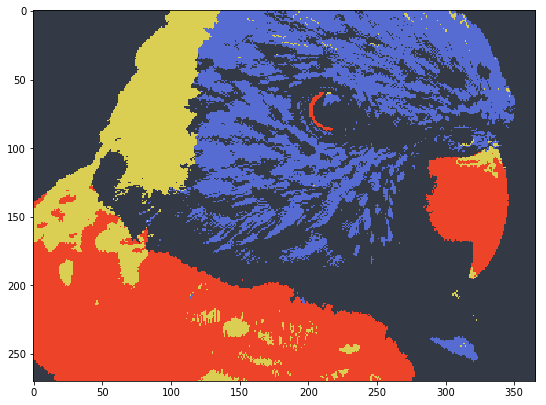

In [8]:
k=4 # number of clusters - feel free to play with it

image_values = image_to_matrix('images/bird_color_24.png')
# Play with the K value below to see the effect number of clusters have
new_image = k_means_segment(image_values, k=k)

plt.figure(None,figsize=(9,12))
plt.imshow(new_image)
plt.show()


You can reuse the K-means visualization code from previous section to show the training progress on the image for different iterations and even numbers of clusters.

- - -

## Part 2: Implementing a Multivariate Gaussian Mixture Model 



In [9]:
def initialize_parameters(X, k):
    """
    Return initial values for training of the GMM
    Set component mean to a random
    pixel's value (without replacement),
    based on the mean calculate covariance matrices,
    and set each component mixing coefficient (PIs)
    to a uniform values
    (e.g. 4 components -> [0.25,0.25,0.25,0.25]).
    
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    
    returns:
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    PI = numpy.ndarray[float] - k x 1 
    """
    #raise NotImplementedError()
    
    m = X.shape[0] # number of rows
    n = X.shape[1] # number of cols
    
    
    #calculate MU    
    #calculate randon mean and return k x n
    MU_elements = np.random.choice(m, k, replace=False) # list of elements to sample
    MU = X[[MU_elements]]
    
    # another SIGMA
    # cov(X) = 1/m*(X-E(X))^T %*% (X-E(X))
    another_sigma = []
    for i in range(k):
        m = X.shape[0]
        first_term = 1/m
        second_term = (X-MU[i]).T
        third_term = X-MU[i]
        calc = first_term * (np.dot(second_term, third_term))
        #print("calc: ", calc)
        another_sigma.append(calc)
    SIGMA = np.array(another_sigma)
    
    # calculate pi
    # create k x 1 array with pi_val for each k
    pi_val = 1.0 / k
    PI = np.full((k, 1), pi_val)
    
    return MU, SIGMA, PI

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_initialization(initialize_parameters)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [10]:
def prob(x, mu, sigma):
    """Calculate the probability of a single
    data point x under component with
    the given mean and covariance.
    # NOTE: there is nothing to vectorize here yet,
    # it's a simple check to make sure you got the
    # multivariate normal distribution formula right
    # which is given by N(x;MU,SIGMA) above

    params:
    x = numpy.ndarray[float]
    mu = numpy.ndarray[float]
    sigma = numpy.ndarray[numpy.ndarray[float]]

    returns:
    probability = float
    """

    #raise NotImplementedError()
    debug = False
    if debug:
        print("shapes: ", x.shape, mu.shape, sigma.shape)
        print("x: ", x)
        print("mu: ", mu)
        print("sigma: ", sigma)
    
    d=len(x)
    det_sigma = np.linalg.det(sigma)
    x_mu = np.matrix(x - mu).T
    sigma_inv = np.linalg.inv(sigma) 
    first_term = 1.0/np.power((2*np.pi),float(d/2))
    second_term = np.power(det_sigma,-0.5)
    third_term = np.exp(-0.5 * (x_mu.T * sigma_inv * x_mu)).item()  
    if debug: 
        print("x_mu.shape: ", x_mu.shape)
        print("sigma_inv.shape: ", sigma_inv.shape)
        print("x_mu.T.shape: ", x_mu.T.shape)
    
    prob = first_term * second_term * third_term
    
    if debug:
        print("shapes: ", x_mu.shape, sigma_inv.shape, x_mu.T.shape)
        print("result: ", prob)

    return prob

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_prob(prob)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [11]:
def E_step(X,MU,SIGMA,PI,k):

    debug = False
    
    #vectorize
    responsibility = []
    for i in range(k):
        d=X.shape[1]
        det_sigma = np.linalg.det(SIGMA[i])
        x_mu = np.array(X - MU[i]) # (98820, 3)
        sigma_inv = np.linalg.inv(SIGMA[i])
        
        first_term = 1.0/np.power((2*np.pi),float(d/2))
        second_term = np.power(det_sigma,-0.5)
        
        totals_array = x_mu[:,:,np.newaxis]
        totals_array_t = x_mu[:,np.newaxis,:]
        totals_sigma_array = sigma_inv[np.newaxis,:,:]
        four_d_dot = np.matmul(np.matmul(totals_array_t,totals_sigma_array), totals_array)

        third_term = np.exp(-0.5 * four_d_dot)   

        resp = first_term * second_term * third_term
        resp = resp.reshape(resp.shape[0])

        this_resp=resp*PI[i]
        responsibility.append(this_resp)
        
    responsibility = np.array(responsibility)
    responsibility = responsibility/np.sum(responsibility, axis=0)
    
    return responsibility         
    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_e_step(E_step)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [12]:
def M_step(X, r, k):
    """
    M-step - Maximization
    Calculate new MU, SIGMA and PI matrices
    based on the given responsibilities.
    
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    r = numpy.ndarray[numpy.ndarray[float]] - k x m
    k = int
    
    returns:
    new_MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    new_SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    new_PI = numpy.ndarray[float] - k x 1
    """

    #raise NotImplementedError()
    
    debug = False
    
    if debug:
        print("r.shape (k x m): ", r.shape)
        print("r[0]: ", r[0])
        print("X.shape: ", X.shape)
        print("X: ", X)
    
    # r = (k x m) = (3, 10)
    # X = (m x n) = (10, 3)
    #MU = (k x n) = (3, 3)
    
    # 1/Nk * sum [gamma(Znk) * Xn]
    new_MU = []
    for i in range(k):
        r_i = r[i]
        #this_mu= np.dot(r[i], X)
        this_mu = r_i[:, np.newaxis]*X
        sums = np.sum(this_mu, axis = 0)
        normed = sums/np.sum(r_i, axis=0)
        #print("normed: ", normed)
        new_MU.append(normed)
    new_MU = np.array(new_MU)
    
    #new_resp_SIGMA
    # cov = 1/Nk * SUM [ gamma(Znk) * (X - MU) * (X - MU).T ]
    new_SIGMA = []
    for i in range(k):
        r_i = r[i]
        
        # cov = 1/Nk * SUM [ gamma(Znk) * (X - MU) * (X - MU).T ]
        Nk = np.sum(r_i, axis=0)
        gamma_Znk = r_i[:, np.newaxis]
        X_MU = X - new_MU[i]
        X_MU_T = (X - new_MU[i]).T
        if debug:
            print("gamma_Znk: ", gamma_Znk.shape)
            print("X_MU: ", X_MU.shape)
            print("X_MU_T: ", X_MU_T.shape)  
        
        X_MU_gamma = X_MU * gamma_Znk
        X_MU_gamma_xmuT = np.dot(X_MU_T, X_MU_gamma)
        result_normed = X_MU_gamma_xmuT/Nk
        if debug:
            print("X_MU_gamma_xmuT: ", X_MU_gamma_xmuT.shape)
            print("X_MU_gamma_xmuT: ", X_MU_gamma_xmuT)
            print("result_normed: ", result_normed)
        new_SIGMA.append(result_normed)
    new_SIGMA = np.array(new_SIGMA)
    
    #new_PI
    new_PI = []
    for i in range(k):    
        this_pi = np.sum(r[i], axis=0)/r[i].shape[0]
        new_PI.append(this_pi)
    new_PI = np.array(new_PI)
    if debug:
        print("new_PI.size (3, 1): ", new_PI.shape)
        print("new pi: ", new_PI)
        print("check 100 pi: ", np.sum(new_PI))
    
    
    
    return new_MU, new_SIGMA, new_PI

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_m_step(M_step)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [13]:
def likelihood(X, PI, MU, SIGMA, k):
    """Calculate a log likelihood to the 
    trained model based on the following
    formula for posterior probability:
    log10(Pr(X | mixing, mean, stdev)) = sum((n=1 to N), log10(sum((k=1 to K),
                                      mixing_k * N(x_n | mean_k,stdev_k))))

    Make sure you are using log base 10, instead of log base 2.
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    PI = numpy.ndarray[float] - k x 1
    k = int

    returns:
    log_likelihood = int
    """
    # TODO: finish this function
    
    debug = False

    #vectorize
    responsibility = []
    for i in range(k):
        d=X.shape[1]
        det_sigma = np.linalg.det(SIGMA[i])
        x_mu = np.array(X - MU[i]) # (98820, 3)
        sigma_inv = np.linalg.inv(SIGMA[i])
        
        first_term = 1.0/np.power((2*np.pi),float(d/2))
        second_term = np.power(det_sigma,-0.5)
        
        totals_array = x_mu[:,:,np.newaxis]
        totals_array_t = x_mu[:,np.newaxis,:]
        totals_sigma_array = sigma_inv[np.newaxis,:,:]
        four_d_dot = np.matmul(np.matmul(totals_array_t,totals_sigma_array), totals_array)

        third_term = np.exp(-0.5 * four_d_dot)   

        resp = first_term * second_term * third_term
        resp = resp.reshape(resp.shape[0])

        this_resp=resp*PI[i]
        responsibility.append(this_resp)
        
    responsibility = np.array(responsibility)
    
    log_likelihood = np.log10(np.sum(responsibility, axis=0))
    
    llk = np.sum(log_likelihood)
    if debug: 
        print("log_likelihood: ", log_likelihood)
        print("llk: ", llk)
        print()
        print("answer expected: ", -23943.0)
        
    return llk
    

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_likelihood(likelihood)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [14]:
def train_model(X, k, convergence_function, initial_values = None):
    """
    Train the mixture model using the 
    expectation-maximization algorithm. 
    Which is an interative execution of
    the E and M steps from above.
    If the initial_values aer None, initialize them.
    Else it's a tuple of the format (MU, SIGMA, PI).
    Convergence is reached when convergence_function
    returns terminate as True,
    see default convergence_function example 
    in `helper_functions.py`

    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    convergence_function = func
    initial_values = None or (MU, SIGMA, PI)

    params:
    returns:
    new_MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    new_SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    new_PI = numpy.ndarray[float] - k x 1
    responsibility = numpy.ndarray[numpy.ndarray[float]] - k x m
    """
    #raise NotImplementedError()
    
    debug = False
    
    if debug:
        
        print("X: ", X.shape)
        print("k: ", k)
        #print("convergence_function: ", convergence_function())
    
    if initial_values is None:
        if debug:
            print("initialize values: ")
        (initial_values) = initialize_parameters(X, k)
    
    new_MU, new_SIGMA, new_PI = initial_values
    
    if debug:
        print("initial_values: ", initial_values)
        print("Mu, Sigma, PI initial: ", new_MU.shape, new_SIGMA.shape, new_PI.shape)
    
    # E_step(X,MU,SIGMA,PI,k):
    # M_step(X, r, k)
    # likelihood(X, PI, MU, SIGMA, k)
    
    not_converged = True
    converged = False
    count = 1
    prev_likelihood = likelihood(X, new_PI, new_MU, new_SIGMA, k)
    #while not_converged and count < 20:
    while not converged:
        if debug:
            print("count: ", count)
            print("start e step")
        
        #responsibility = E_step(X,new_MU,new_SIGMA,new_PI,k)
        
        responsibility = []
        for i in range(k):
            d=X.shape[1]
            det_sigma = np.linalg.det(new_SIGMA[i])
            x_mu = np.array(X - new_MU[i]) # (98820, 3)
            sigma_inv = np.linalg.inv(new_SIGMA[i])

            first_term = 1.0/np.power((2*np.pi),float(d/2))
            second_term = np.power(det_sigma,-0.5)

            totals_array = x_mu[:,:,np.newaxis]
            totals_array_t = x_mu[:,np.newaxis,:]
            totals_sigma_array = sigma_inv[np.newaxis,:,:]
            four_d_dot = np.matmul(np.matmul(totals_array_t,totals_sigma_array), totals_array)

            third_term = np.exp(-0.5 * four_d_dot)   

            resp = first_term * second_term * third_term
            resp = resp.reshape(resp.shape[0])

            this_resp=resp*new_PI[i]
            responsibility.append(this_resp)
        
        responsibility = np.array(responsibility)
        responsibility = responsibility/np.sum(responsibility, axis=0)
        
        
        if debug:
            print("start m step")
        #new_MU, new_SIGMA, new_PI = M_step(X, responsibility, k)
        
        new_MU = []
        for i in range(k):
            r_i = responsibility[i]
            this_mu = r_i[:, np.newaxis]*X
            sums = np.sum(this_mu, axis = 0)
            normed = sums/np.sum(r_i, axis=0)
            #print("normed: ", normed)
            new_MU.append(normed)
        new_MU = np.array(new_MU)

        new_SIGMA = []
        for i in range(k):
            r_i = responsibility[i]
            Nk = np.sum(r_i, axis=0)
            gamma_Znk = r_i[:, np.newaxis]
            X_MU = X - new_MU[i]
            X_MU_T = (X - new_MU[i]).T
            X_MU_gamma = X_MU * gamma_Znk
            X_MU_gamma_xmuT = np.dot(X_MU_T, X_MU_gamma)
            result_normed = X_MU_gamma_xmuT/Nk
            new_SIGMA.append(result_normed)
        new_SIGMA = np.array(new_SIGMA)

        new_PI = []
        for i in range(k):    
            this_pi = np.sum(responsibility[i], axis=0)/responsibility[i].shape[0]
            new_PI.append(this_pi)
        new_PI = np.array(new_PI)
               
        
        if debug:
            print("start likelihood")
        new_likelihood = likelihood(X, new_PI, new_MU, new_SIGMA, k)
        cnt, converged = convergence_function(prev_likelihood, new_likelihood, count)
        diff = new_likelihood - prev_likelihood
        count=cnt
        if debug:
            print("lkl: ", prev_likelihood)
            print("new lkl: ", new_likelihood)
            print("values: ", np.sum(new_MU), np.sum(new_SIGMA), new_PI)
            print("converged: ", converged)
            print("cnt: ", cnt)
            print("diff: ", diff)
            print()
        if diff > 90000:
            not_converged = False
        prev_likelihood = new_likelihood
        
        
    return new_MU, new_SIGMA, new_PI, responsibility
        

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_train(train_model, likelihood)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [15]:
def cluster(r):
    """
    Based on a given responsibilities matrix
    return an array of clusters.
    Assign each datapoint to a cluster based,
    on component with a max-likelihood 
    (maximum responsibility value).
    
    params:
    r = numpy.ndarray[numpy.ndarray[float]] - k x m - responsibility matrix
    
    return:
    clusters = numpy.ndarray[int] - m x 1 
    """

    #raise NotImplementedError()
    debug = False
    if debug:
        print("r: ", r.shape)
        print("r: ", r.shape[0])
        print("r tran:\n ", r.T)
        print("r argmax: ", np.argmax(r.T, axis=1))
    
    
    #old
    #sum_rows = np.sum(r, axis=0)
    #clusters = np.array(sum_rows)[:,np.newaxis].astype(int)
    #means = get_initial_means(r.T, r.shape[0])
    #new_means, clusters = k_means_step(r.T, r.shape[0], means)
        
    clusters = np.argmax(r.T, axis=1)
    
    return clusters

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_cluster(cluster)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [18]:
def segment(X, MU, k, r):
    """
    Segment the X matrix into the pre-specified
    number of components. Returns the matrix with 
    the each data point replace with its max-likelihood
    component mean. E.g in case of image returns 
    the original matrix with the each pixel's 
    intensity replaced with its max-likelihood
    component mean. (the shape is still mxn,
    not original image size)

    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    k = int
    r = numpy.ndarray[numpy.ndarray[float]] - k x m - responsibility matrix

    returns:
    new_X = numpy.ndarray[numpy.ndarray[float]] - m x n
    """

    #raise NotImplementedError()
    
    new_X = np.empty(X.shape)
    clusters = cluster(r)
    #print("clusters: ", clusters)
    
    for i in range(X.shape[0]):
        cluster_val = clusters[i]
        new_X[i]= MU[cluster_val]
    #print("new_X: ", new_X.shape)
    return new_X
        

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_segment(train_model, segment)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [19]:
def best_segment(X,k,iters):
    """Determine the best segmentation
    of the image by repeatedly
    training the model and
    calculating its likelihood.
    Return the segment with the
    highest likelihood.

    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    iters = int

    returns:
    likelihood = float
    segment = numpy.ndarray[numpy.ndarray[float]]
    """

    #raise NotImplementedError()
    
    likelihoods = []
    segments = []
    for i in range(iters):
        #print("iters: ", i)
        new_MU, new_SIGMA, new_PI, responsibility = train_model(X, k, convergence_function=default_convergence, initial_values = None)
        new_likelihood = likelihood(X, new_PI, new_MU, new_SIGMA, k)
        likelihoods.append(new_likelihood)
        new_segment = segment(X, new_MU, k, responsibility)
        segments.append(new_segment)
    best = np.argmax(likelihoods)
    
    #print("", likelihoods[best])
    #print()
    #print(segments[best])
    return likelihoods[best], segments[best]
    
        
        

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_best_segment(best_segment)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


#### GMM - Visualizing the results




In [20]:
def GMM_2D_dataset(dataset_index, K):
    # Load the dataset from data folder
    X = np.loadtxt("data/%d_dataset_X.csv" % dataset_index, delimiter=",")
    print("There are %d datapoints in the current dataset, each of a size %d" % X.shape)
    # Load the labels
    # Clustering is unsupervised method, where no labels are provided
    # However, since we generated the data outselves we know the labels,
    # and load them for illustration purposes.
    y = np.int16(np.loadtxt("data/%d_dataset_y.csv" % dataset_index, delimiter=","))
    # Feel free to edit the termination condition for the EM algorithm
    # Currently is just runs for n_iterations, before terminating
    
    MU, SIGMA, PI = initialize_parameters(X, K)
    
    clusters_history = []
    for _ in range(200):
        r = E_step(X,MU,SIGMA,PI,K)
        new_MU, new_SIGMA, new_PI = M_step(X, r, K)
        PI, MU, SIGMA = new_PI, new_MU, new_SIGMA
        clusters = cluster(r)
        clusters_history.append(clusters)

    return X, y, clusters_history

In [21]:
# TRY DIFFERENT PARAMETERS
dataset_index = 3 # for different dataset change it to number from [0,5]
K = 3 # Number of clusters - play with this number

X, y, clusters_history = GMM_2D_dataset(dataset_index, K)

# This is an interactive cell to see the progress of training your GMM algorithm.
# Feel free to improve the visualization code and share it with your classmates on Piazza.
def get_cluster(i):
    clusters = clusters_history[i] # Get the clusters from K-means' i-th iteration
    plt.figure(None, figsize=(15,6)) # Set the plot size
    plt.suptitle('Drag the slider to see the algorthm training progress')
    ax1=plt.subplot(1, 2, 1)
    ax1.set_title('K-means clsuters - step %d' % i)
    for k in range(K):
        plt.plot(X[clusters==k,0], X[clusters==k,1], '.') # 
        # Try to plot the centers of the clusters 
        # You can access them by calling means_history[i]
        # How could you plot the area that belong to that cluster?

    # Just to get a flavour of how the data looks like
    ax2=plt.subplot(1, 2, 2)
    ax2.set_title('Ground truth clusters')
    for i in np.unique(y):
        ax2.plot(X[y==i,0],X[y==i,1],'.')

    plt.show()

interactive(get_cluster, i=(0,len(clusters_history)-1,1))

There are 1000 datapoints in the current dataset, each of a size 2


interactive(children=(IntSlider(value=99, description='i', max=199), Output()), _dom_classes=('widget-interact…

### Let's visualize the image compression results of GMM.

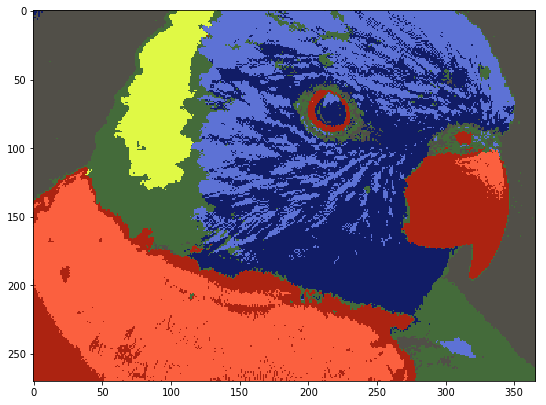

In [22]:
image_file = 'images/bird_color_24.png' # Image path
original_image_matrix = image_to_matrix(image_file) # Save original image
image_matrix = original_image_matrix.reshape(-1,3) # collapse the dimension
K = 7 # K

_, best_seg = best_segment(image_matrix, K, iters = 10)
new_image = best_seg.reshape(*original_image_matrix.shape) # reshape collapsed matrix to original size
# Show the image
plt.figure(None,figsize=(9,12))
plt.imshow(new_image)
plt.show()

---

## Part 3: Model Experimentation 

We'll now experiment with a few methods for improving GMM performance. For example improved initialization.





In [ ]:
def improved_initialization(X,k):
    """
    Initialize the training
    process by setting each
    component mean using some algorithm that
    you think might give better means to start with,
    based on the mean calculate covariance matrices,
    and set each component mixing coefficient (PIs)
    to a uniform values
    (e.g. 4 components -> [0.25,0.25,0.25,0.25]).
    
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    
    returns:
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    PI = numpy.ndarray[float] - k x 1 
    """

    #raise NotImplementedError()
    
    m = X.shape[0] # number of rows
    n = X.shape[1] # number of cols
    
    all_means=[]
    all_clusters=[]
    for i in range(10):
        initial_means = get_initial_means(X, k)
        means_not_converged = True
        #print("k", k)
        count = 0
        while means_not_converged:
            old_means = np.copy(initial_means)
            initial_means, clusters = k_means_step(X, k, initial_means)
            if count > 0:
                converged = clusters == clusters_old

                if converged.all():
                    means_not_converged = False
            clusters_old = np.copy(clusters)
            count = count+1        
        all_means.append(initial_means)
        this_cluster_amounts=[]
        for x in range(k):
            this_cluster_amounts.append(np.sum(clusters==x))
        max_amount = np.max(this_cluster_amounts)
        all_clusters.append(max_amount)
    max_mean_index = np.argmax(all_clusters)
    MU = all_means[max_mean_index]
    
    #MU = initial_means
    #print("clusters: ", np.sum(clusters==0), np.sum(clusters==1), np.sum(clusters==2), np.sum(clusters==3), np.sum(clusters==4))
    
    
    #old MU    
    #calculate randon mean and return k x n
    #MU_elements = np.random.choice(m, k, replace=False) # list of elements to sample
    #MU = X[[MU_elements]]
    #print("MU: ", MU.shape)
    
    # another SIGMA
    # cov(X) = 1/m*(X-E(X))^T %*% (X-E(X))
    another_sigma = []
    for i in range(k):
        m = X.shape[0]
        first_term = 1/m
        second_term = (X-MU[i]).T
        third_term = X-MU[i]
        calc = first_term * (np.dot(second_term, third_term))
        #print("calc: ", calc)
        another_sigma.append(calc)
    SIGMA = np.array(another_sigma)
    
    # calculate pi
    # create k x 1 array with pi_val for each k
    pi_val = 1.0 / k
    PI = np.full((k, 1), pi_val)
    
    return MU, SIGMA, PI

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_improvement(improved_initialization, initialize_parameters, train_model, likelihood)
################ END OF LOCAL TEST CODE SECTION ######################

## Part 3b: Convergence Condition

7.5 points

You might be skeptical of the convergence criterion we've provided in `default_convergence()`. To test out another convergence condition, implement `new_convergence_condition()` to return true if all the new model parameters (means, variances, and mixing coefficients) are within 10% of the previous variables for 10 consecutive iterations. This will mean re-implementing `train_model()`, which you will also do in `train_model_improved()` function.

In [ ]:
def new_convergence_function(previous_variables, new_variables, conv_ctr,
                             conv_ctr_cap=10):
    """
    Convergence function
    based on parameters:
    when all variables vary by
    less than 10% from the previous
    iteration's variables, increase
    the convergence counter.

    params:

    previous_variables = [numpy.ndarray[float]]
                         containing [means, variances, mixing_coefficients]
    new_variables = [numpy.ndarray[float]]
                    containing [means, variances, mixing_coefficients]
    conv_ctr = int
    conv_ctr_cap = int

    return:
    conv_ctr = int
    converged = boolean
    """

    
#     increase_convergence_ctr = (abs(prev_likelihood) * 0.9 < abs(new_likelihood) < abs(prev_likelihood) * 1.1)
#     if increase_convergence_ctr:
#         conv_ctr += 1
#     else:
#         conv_ctr = 0

#     return conv_ctr, conv_ctr > conv_ctr_cap
    
    #print("previous variables: ")
    #print(previous_variables)
    #print("new_variables")
    #print(new_variables)
    
    prev_means = previous_variables[0]
    #print("prev_means: ", prev_means.shape)
    prev_sigma = previous_variables[1]
    #print("prev_sigma: ", prev_sigma.shape)
    prev_pi = previous_variables[2]
    #print("prev_pi: ", prev_pi.shape)
    
    new_means = new_variables[0]
    #print("new_means: ", new_means.shape)
    new_sigma = new_variables[1]
    #print("new_sigma: ", new_sigma.shape)
    new_pi = new_variables[2]
    #print("new_pi: ", new_pi.shape)
    
    #print(new_means - prev_means)
    #print(prev_means *.9)
    #print(new_means)
    #print(prev_means * 1.1)
    #print("1 check: ", (prev_means * .9 < new_means).all())
    
    threshold = .05
    
    mean_low_converge = (abs(prev_means) * (1.0-threshold) < abs(new_means)).all()
    mean_high_converge = (abs(new_means) < abs(prev_means) * (1.0 + threshold)).all()
    sigma_low_converge = (abs(prev_sigma) * (1.0-threshold) < abs(new_sigma)).all()
    sigma_high_converge = (abs(new_sigma) < abs(prev_sigma) * (1.0 + threshold)).all()
    pi_low_converge = (abs(prev_pi) * (1.0-threshold) < abs(new_pi)).all()
    pi_high_converge = (abs(new_pi) < abs(prev_pi) * (1.0 + threshold)).all()
    
    #print(mean_low_converge, mean_high_converge)
    #print(sigma_low_converge, sigma_high_converge)
    #print(pi_low_converge, pi_high_converge)
    
    if mean_low_converge and mean_high_converge and sigma_low_converge and sigma_high_converge and pi_low_converge and pi_high_converge:
        #print("converged")
        increase_convergence_ctr = True
    else: 
        increase_convergence_ctr = False
        
    if increase_convergence_ctr:
        conv_ctr += 1
    else:
        conv_ctr = 0

    #print(conv_ctr, conv_ctr > conv_ctr_cap)    
    return conv_ctr, conv_ctr > conv_ctr_cap

    

def train_model_improved(X, k, convergence_function, initial_values = None):
    """
    Train the mixture model using the 
    expectation-maximization algorithm. 
    Which is an interative execution of
    the E and M steps from above.
    Convergence is reached when convergence_function
    returns terminate as True,
    see default convergence_function example 
    in `helper_functions.py`

    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    convergence_function = func
    initial_values = None or (MU, SIGMA, PI)

    params:
    returns:
    new_MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    new_SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    new_PI = numpy.ndarray[float] - k x 1
    responsibility = numpy.ndarray[numpy.ndarray[float]] - k x m
    """

    debug = False
    
    if debug:
        
        print("X: ", X.shape)
        print("k: ", k)
        #print("convergence_function: ", convergence_function())
    
    if initial_values is None:
        if debug:
            print("initialize values: ")
        (initial_values) = improved_initialization(X, k)
    
    new_MU, new_SIGMA, new_PI = initial_values
    
    if debug:
        print("initial_values: ", initial_values)
        print("Mu, Sigma, PI initial: ", new_MU.shape, new_SIGMA.shape, new_PI.shape)
    
    # E_step(X,MU,SIGMA,PI,k):
    # M_step(X, r, k)
    # likelihood(X, PI, MU, SIGMA, k)
    
    not_converged = True
    converged = False
    count = 1
    prev_likelihood = likelihood(X, new_PI, new_MU, new_SIGMA, k)
    prev_variables = [new_MU, new_SIGMA, new_PI]
    #while not_converged and count < 20:
    while not converged:
        if debug:
            print("count: ", count)
            print("start e step")
        
        #responsibility = E_step(X,new_MU,new_SIGMA,new_PI,k)
        
        responsibility = []
        for i in range(k):
            d=X.shape[1]
            det_sigma = np.linalg.det(new_SIGMA[i])
            x_mu = np.array(X - new_MU[i]) # (98820, 3)
            sigma_inv = np.linalg.inv(new_SIGMA[i])

            first_term = 1.0/np.power((2*np.pi),float(d/2))
            second_term = np.power(det_sigma,-0.5)

            totals_array = x_mu[:,:,np.newaxis]
            totals_array_t = x_mu[:,np.newaxis,:]
            totals_sigma_array = sigma_inv[np.newaxis,:,:]
            four_d_dot = np.matmul(np.matmul(totals_array_t,totals_sigma_array), totals_array)

            third_term = np.exp(-0.5 * four_d_dot)   

            resp = first_term * second_term * third_term
            resp = resp.reshape(resp.shape[0])

            this_resp=resp*new_PI[i]
            responsibility.append(this_resp)
        
        responsibility = np.array(responsibility)
        responsibility = responsibility/np.sum(responsibility, axis=0)
        
        
        if debug:
            print("start m step")
        #new_MU, new_SIGMA, new_PI = M_step(X, responsibility, k)
        
        new_MU = []
        for i in range(k):
            r_i = responsibility[i]
            this_mu = r_i[:, np.newaxis]*X
            sums = np.sum(this_mu, axis = 0)
            normed = sums/np.sum(r_i, axis=0)
            #print("normed: ", normed)
            new_MU.append(normed)
        new_MU = np.array(new_MU)

        new_SIGMA = []
        for i in range(k):
            r_i = responsibility[i]
            Nk = np.sum(r_i, axis=0)
            gamma_Znk = r_i[:, np.newaxis]
            X_MU = X - new_MU[i]
            X_MU_T = (X - new_MU[i]).T
            X_MU_gamma = X_MU * gamma_Znk
            X_MU_gamma_xmuT = np.dot(X_MU_T, X_MU_gamma)
            result_normed = X_MU_gamma_xmuT/Nk
            new_SIGMA.append(result_normed)
        new_SIGMA = np.array(new_SIGMA)

        new_PI = []
        for i in range(k):    
            this_pi = np.sum(responsibility[i], axis=0)/responsibility[i].shape[0]
            new_PI.append(this_pi)
        new_PI = np.array(new_PI)
               
        
        if debug:
            print("start likelihood")
        new_likelihood = likelihood(X, new_PI, new_MU, new_SIGMA, k)
        new_variables = [new_MU, new_SIGMA, new_PI]
        cnt, converged = new_convergence_function(prev_variables, new_variables, count)
        diff = new_likelihood - prev_likelihood
        count=cnt
        if debug:
            print("lkl: ", prev_likelihood)
            print("new lkl: ", new_likelihood)
            print("values: ", np.sum(new_MU), np.sum(new_SIGMA), new_PI)
            print("converged: ", converged)
            print("cnt: ", cnt)
            print("diff: ", diff)
            print()
        if diff > 90000:
            not_converged = False
        prev_likelihood = new_likelihood
        prev_variables = new_variables
        
        
    return new_MU, new_SIGMA, new_PI, responsibility

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
# Unittest below will check both of the functions at the same time. 
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_convergence_condition(improved_initialization, train_model_improved, initialize_parameters, train_model, likelihood, new_convergence_function)
################ END OF LOCAL TEST CODE SECTION ######################

## Part 4: Bayesian Information Criterion (20 pts)


To avoid overfitting, we can use the [Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (a.k.a. BIC) which penalizes models based on the number of parameters they use. In the case of the Gaussian mixture model, this is equal to the number of components times the number of variables per component (mean, variance and mixing coefficient).




In [ ]:
def bayes_info_criterion(X, PI, MU, SIGMA, k):
    """
    See description above
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    PI = numpy.ndarray[float] - k x 1
    k = int
    
    return:
    bayes_info_criterion = int
    """
    
    # BIC = ln(n)k -2ln(L)
    m = X.shape[0]
    n = X.shape[1]
    L = likelihood(X, PI, MU, SIGMA, k)
    k_n_size = k * n
    image_size = m * n
    
    BIC = np.log(image_size) * k_n_size -2*L 
    #print("BIC: ", BIC)
    
    return BIC


########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_bayes_info(bayes_info_criterion)
################ END OF LOCAL TEST CODE SECTION ######################

## Part 4b: Test BIC

Use the BIC and likelihood to determine the optimal number of components in the `bird_color_24` image.

In [ ]:
def BIC_likelihood_model_test():
    """Test to compare the
    models with the lowest BIC
    and the highest likelihood.

    returns:
    n_comp_min_bic = int
    n_comp_max_likelihood = int

    for testing purposes:
    comp_means = [
        np.array([[0.67644833, 0.63705593, 0.34151605],
               [0.82106333, 0.803725  , 0.38302438]]),
        np.array([[0.67644833, 0.63705593, 0.34151605],
               [0.82106333, 0.803725  , 0.38302438],
               [0.48719558, 0.43396747, 0.57330976]]),
        np.array([[0.67644833, 0.63705593, 0.34151605],
               [0.82106333, 0.803725  , 0.38302438],
               [0.48719558, 0.43396747, 0.57330976],
               [0.37512508, 0.7997302 , 0.64795305]]),
        np.array([[0.67644833, 0.63705593, 0.34151605],
               [0.82106333, 0.803725  , 0.38302438],
               [0.48719558, 0.43396747, 0.57330976],
               [0.37512508, 0.7997302 , 0.64795305],
               [0.14751079, 0.351123  , 0.75471674]]),
        np.array([[0.67644833, 0.63705593, 0.34151605],
               [0.82106333, 0.803725  , 0.38302438],
               [0.48719558, 0.43396747, 0.57330976],
               [0.37512508, 0.7997302 , 0.64795305],
               [0.14751079, 0.351123  , 0.75471674],
               [0.56489468, 0.87895182, 0.25817842]]),
        np.array([[0.67644833, 0.63705593, 0.34151605],
               [0.82106333, 0.803725  , 0.38302438],
               [0.48719558, 0.43396747, 0.57330976],
               [0.37512508, 0.7997302 , 0.64795305],
               [0.14751079, 0.351123  , 0.75471674],
               [0.56489468, 0.87895182, 0.25817842],
               [0.08769436, 0.80069854, 0.50162118]])
        ]
    """

    #raise NotImplementedError()
    #print("start")
    BICs = []
    likelihoods = []
    for mean in comp_means:
        #print("mean: ", mean)
        MU, SIGMA, PI, r = train_model_improved(X, k, new_convergence_function, initial_values = mean)
        this_BIC = bayes_info_criterion(X, PI, MU, SIGMA, k)
        this_likelihood = likelihood(X, PI, MU, SIGMA, k)
        BICs.append(this_BIC)
        likelihoods.append(this_likelihood)
    n_comp_min_bic = comp_means[np.argmin(BICs)].shape[0]
    n_comp_max_likelihood = comp_means[np.argmax(likelihoods)].shape[0]
    #print(n_comp_min_bic, n_comp_max_likelihood)
    
    return n_comp_min_bic, n_comp_max_likelihood

In [ ]:
def BIC_likelihood_question():
    """
    Choose the best number of
    components for each metric
    (min BIC and maximum likelihood).

    returns:
    pairs = dict
    """
       
    bic = 7 
    likelihood = 7
    #bic, likelihood = BIC_likelihood_model_test() 
    pairs = {
        'BIC': bic,
        'likelihood': likelihood
    }
    return pairs

In [ ]:
def bonus(points_array, means_array):
    """
    Return the distance from every point in points_array
    to every point in means_array.

    returns:
    dists = numpy array of float
    """
    # TODO: fill in the bonus function
    # REMOVE THE LINE BELOW IF ATTEMPTING BONUS
    #raise NotImplementedError()
    return dists

# There are no local test for thus question, fill free to create them yourself.
# Feel free to play with it in a separate python file, and then just copy over 
# your implementation before the submission.

---

## Congrats, you are done with the part of the assignment which is graded
### Please follow the instructions in the README to submit your code for grading.

- - -


Next is as promised segmentation of the Point Cloud data. 

In order to run the code below you first need to install an `open3d` library. If you used `pip install -r requirements.txt` command for this assignment, it should already be installed. Else, you can install it `pip install open3d-python` command, if you used virtual environment, make sure to activate it before running the code.

You can also refer to official Open3d documentation http://www.open3d.org/docs/getting_started.html for details about the installation and library itself.

RGBD (**RGB** + **D**epth) data is usually stored as two separated images, one contains RGB (color) information and second one contains only depth, thus is a grayscale image. Let's load a data sample visualize it.

In [ ]:
from open3d import * 

In [ ]:
# Function below load the data
def load_rgbd_image(image_path, depth_path):
    color_raw = read_image(image_path)
    depth_raw = read_image(depth_path)
    #  details about function http://www.open3d.org/docs/tutorial/Basic/rgbd_odometry.html
    # We are using a data sample from the SUN RGB-D (http://rgbd.cs.princeton.edu/) dataset
    return color_raw, depth_raw

# We can plot these images separately using the function below
def plot_rgbd(color_image, depth_image):
    plt.figure(None,(15,15))
    plt.subplot(1, 3, 1)
    plt.title('Color image')
    plt.imshow(color_image)
    plt.subplot(1, 3, 2)
    plt.title('SUN depth image')
    plt.imshow(depth_image)
    plt.show()

In [ ]:
import glob
rgbd_dataset = glob.glob('rgbd/image/*.jpg') # TODO fix it
image_number = 3 # [0,4] there are five different images in the folder

image_file = rgbd_dataset[image_number]
depth_file = image_file.replace('image','depth')[:-4] + '.png'
assert os.path.isfile(image_file); 
assert os.path.isfile(depth_file);
color_image, depth_image = load_rgbd_image(image_file, depth_file)
plot_rgbd(color_image, depth_image)

In [ ]:
# Next we can convert the depth image into a point cloud 
def show_point_cloud(color_raw, depth_raw):
    rgbd_image = create_rgbd_image_from_sun_format(color_raw, depth_raw);
    pcd = create_point_cloud_from_rgbd_image(rgbd_image, 
                 PinholeCameraIntrinsic(PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    # Flip it, otherwise the pointcloud will be upside down
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    draw_geometries([pcd])
    return pcd

In [ ]:
pcd = show_point_cloud(color_image, depth_image)

In [ ]:
# Lets have a look at the structure of the point cloud data
pcd_points = np.asarray(pcd.points)
print("Point cloud data - shape:", pcd_points.shape)

Point cloud data is represented as an unsorted set of the size M x N., where M is the number of points and N is the x,y,z value for each point. If you are interested you can access the color data in `pcd.colors`.

Let us try to perform a segmentation on the image we just loaded.

In [ ]:
# Setting the number of clusters
K = 5
# Note: it's just a simple train model run
# To improve it you can adapt the best_segment() 
# to generate the clusters with the best model
initial_params = initialize_parameters(pcd_points, K)
MU, SIGMA, PI, r = train_model(pcd_points, K,
                               convergence_function=default_convergence,
                               initial_values=initial_params)
clusters = cluster(r)

In [ ]:
# Generate a set of size K of distinct color to plot the clusters
# Adapted from https://stackoverflow.com/questions/876853/generating-color-ranges-in-python
import colorsys
HSV_tuples = [(x*1.0/K, 1.0, 1.0) for x in range(K)]
color_maps = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

### Visualizing the segmented point cloud data!

In [ ]:
or_pcd = PointCloud() # Create new point cloud handler
or_pcd.points = Vector3dVector(pcd_points) # set point cloud data
colors = np.zeros_like(pcd_points) # initialize colors to 0
for i, point in enumerate(np.unique(clusters)):
    random_color = color_maps[i]
    cluster_mask = (clusters == point) # get the mask of the cluster i
    colors[cluster_mask,:] = random_color # set random color to all the point of this segment
or_pcd.colors = Vector3dVector(colors) # set color data
draw_geometries([or_pcd]) # visualize point cloud

Some questions to think about:
- Would adding a color help or harm the segmentation results?
- How about the case: segment RGB data -> add depth -> convert to Point Cloud -> cluster? Would that help/harm?
- Could you think of a way you could compress the point cloud data?

Things to try:
- Segmentation here is done in purely unsupervised manner, you could manually combine multiple gaussian
- How about merging multiple scenes into a single one? You could crop one segment from one scene and place it inside another scene.
- Try K-means on point cloud data and see what results does it produces
- Can we omit the step of conversion to point cloud? And use depth only? Or depth with x,y coordinates?

### ~END~